# Actividad 1 - Alex Herrerías Ramírez

Primero cargaremos todas las librerias y modelos que voy a utilizar a lo largo del ejercicio.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, classification_report

Vamos a cargar el dataset y hacer un vistazo inicial

In [5]:
try: 
    df = pd.read_csv("airbnb.csv")
except FileNotFoundError:
    print("No se encontro el fichero")

In [6]:
print("Información general")
df.info()

Información general
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


In [7]:
print("Primeras 5 filas")
df.head()

Primeras 5 filas


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


In [8]:
print("Valores nulos")
df.isnull().sum()

Valores nulos


neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Antes de empezar con el estudio y limpieza de datos de la variable a predecir (room_type), podemos observar que no tenemos valores nulos y que es de tipo object (texto), por lo que es necesario codificar la variable usando _LabelEncoder_ para convertirla en números y podamos usarla en modelos.

Podemos observar que hay dos atributos categóricos aparte de "room_type", que son "neighbourhood_group" y "neighbourhood", estos atributos seran transformados a números usando un _OneHotEncoder_, mas adelante discutiremos la estrategia exacta utilizada.

El resto de atributos son numericos pero muestran escalas muy diferentes, por lo que hará falta aplicar un escalado a todos los atributos numericos para poder entrenar el modelo correctamente.

Vamos a realizar un breve análisis estadístico sobre las variables numericas para poder hacernos una idea mas concreta de que tipo de escalado se le puede llegar a aplicar

In [9]:
print("Estadística Descriptiva")
print(df.describe())

Estadística Descriptiva
           latitude     longitude         price  minimum_nights  \
count  13321.000000  13321.000000  13321.000000    13321.000000   
mean      40.420730     -3.697268     69.171834        3.010885   
std        0.020344      0.023832    103.721126       12.835619   
min       40.331888     -3.863907      9.000000        1.000000   
25%       40.410090     -3.707856     31.000000        1.000000   
50%       40.418731     -3.701602     53.000000        2.000000   
75%       40.427997     -3.693818     80.000000        3.000000   
max       40.562736     -3.526821   7700.000000     1125.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       13321.000000       13321.000000                    13321.000000   
mean           22.986037           1.520329                        7.605885   
std            38.406006           1.852367                       19.619972   
min             0.000000           0.000000             

Podemos observar que algunas variables tienen escalas en rangos muy diferentes, mientras que la longitud y latitud estan en un rango muy estrecho y apenas se desvián, el precio tiene una media de 103 y un maximo de 7700 y las reviews_per_month tiene una media de 1.5, por lo que el escalado en mi opinión es obligatorio.
Para el escalado, usaremos el _StandardScaler_ para las primeras pruebas, si es necesario, se exploraran otras vías.

Distribución de room_type
room_type
Entire home/apt    7926
Private room       5203
Shared room         192
Name: count, dtype: int64


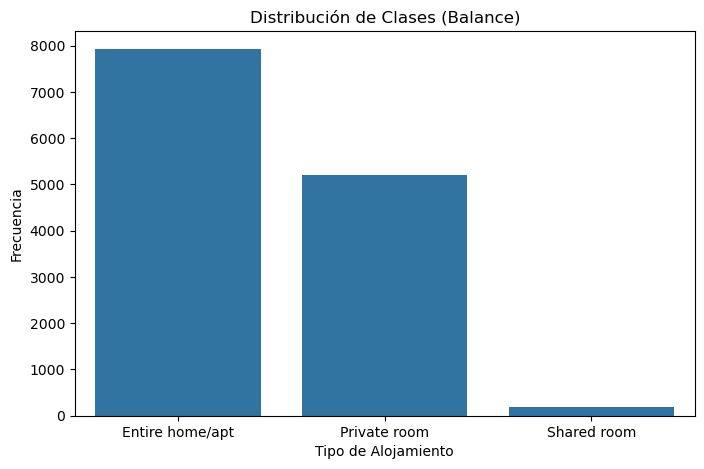

In [10]:
# Analisis de la variable objetivo
print("Distribución de room_type")
clases_objetivo = df["room_type"].value_counts()
print(clases_objetivo)

plt.figure(figsize=(8, 5))
sns.countplot(x="room_type", data=df, order=clases_objetivo.index)
plt.title("Distribución de Clases (Balance)")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de Alojamiento")
plt.show()

En el gráfico podemos observar que claramente, las clases estan totalmente desbalanceadas, siendo la mayoria de estas "Entire home/apt" con 7926 instancias, seguido de "Privade room" con 5203 instancias y por ultimo una clase minoritaria "Shared room" con tan solo 192 instancias.

Debido a tal desbalance, vamos a tomar las siguientes decisiones para cada algoritmo que se nos pide en el enunciado:

- En la __división de datos__, debemos asegurarnos que la proporción desbalanceada se mantenga tanto en el conjunto de entrenamiento como en el de test, esto lo haremos usando _stratify=y_ al hacer el _train_test_split_.

- En los __arboles de decisión__, aplicaremos el parametro _class_weight="balanced"_, asi nos aseguraremos que el algoritmo penaliza mas los errores en la clase minoritaria.

- Para __KNN__ y __Naive Bayes__, no podemos usar un parametro para controlar el desbalanceo, asi que tendremos que estar pendientes de las metricas para asegurarnos de que el modelo no ignora la clase minoritaria.


# Preprocesamiento de los datos

Codificaremos la variable objetivo (y) usando _LabelEncoder_ para "room_type"

In [12]:
# Separamos el dataset de la variable objetivo y codificamos room_type
X = df.drop("room_type", axis=1)
y_uncoded = df["room_type"]
le = LabelEncoder()
y = le.fit_transform(y_uncoded)
print(f"Clases de room_type codificadas {list(le.classes_)} : {np.unique(y)}")

Clases de room_type codificadas ['Entire home/apt', 'Private room', 'Shared room'] : [0 1 2]


Una vez tenemos la variable objetivo codificada, debemos separar las columnas numericas de las categoricas para poder procesarlas por separado

In [13]:
clases_numericas = X.select_dtypes(include=["int64","float64"]).columns
clases_categoricas = X.select_dtypes(include=["object"]).columns

print(f"Columnas numericas: {list(clases_numericas)}")
print(f"Columnas categoricas: {list(clases_categoricas)}")

Columnas numericas: ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Columnas categoricas: ['neighbourhood_group', 'neighbourhood']


Para las columnas numericas, le aplicaremos un _SimpleImputer_ (aunque en nuestro caso no tengamos valores nulos, se requiere por el enunciado y nunca esta de más para posibles futuros datos) usando la mediana, posteriormente aplicaremos _StandardScaler_ el cual es necesario para _KNN_ y las escalas.

Para las columnas categoricas, volveremos a usar un _SimpleImputer_ con la estrategia del más frecuente, y posteriormente un _OneHotEncoder_ que ignorara los posibles nulos.

Debido a que vamos a usar un _OneHotEncoder_ en las variables categoricas, se genera un problema para los modelos de _Naive Bayes_ , ya que nuestro dataset preprocesado contendrá una mezcla de datos numéricos escalados (continuos, algunos negativos por _StandardScaler_) y datos binarios (0/1 del OHE).

Cada variante de _Naive Bayes_ tiene un enfoque y resultados dependiendo de como seán los datos:

- __GaussianNB__: Asume que todas las _features_ son continuas y siguen una distribución normal . Esto es incorrecto  para nuestro caso debido a que el _OHE_ creara cientos de columnas binarias.

- __BernoulliNB__: Asume que todas las _features_ son binarias (0 o 1). Esto es incorrecto para las features numéricas escaladas, pero funcionara correctamente a priori con el _OHE_.

- __MultinomialNB__ / __ComplementNB__: Asumen que todas las _features_ son "conteos" (enteros no negativos). Nuestro _StandardScaler_ (definido en la siguiente celda) produce valores negativos, lo cual causará un error en estos modelos.

## Estrategia: Probar todas las variantes
En lugar de asumir qué modelo es el "menos malo", realizaremos una pequeña evaluación comparativa como se ha aconsejado en el foro de la asignatura después de la división de datos para ver cuál se adapta mejor:
- Probaremos _GaussianNB_ y _BernoulliNB_ con el preprocesador principal (_StandardScaler_ + _OneHotEncoder_).
- Para _MultinomialNB_ y _ComplementNB_, tendremos que crear un preprocesador numérico alternativo que use _MinMaxScaler_ para evitar los valores negativos y cumplir con sus requisitos.
- Continuaremos el resto de la práctica con el modelo NB que ofrezca el mejor accuracy en esta comparativa.

In [15]:
transformador_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, clases_numericas),
        ('cat', transformador_categorico, clases_categoricas)
    ],
    remainder='passthrough'
)
print(f"\nPreprocesadores creados.")



Preprocesadores creados.


# Entrenamiento y Validación


In [ ]:
# Separamos el conjunto de datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

print(f"Tamaño entrenamiento: {X_train.shape[0]} muestras ({len(y_train)} etiquetas)")
print(f"Tamaño test: {X_test.shape[0]} muestras ({len(y_test)} etiquetas)")

Tamaño entrenamiento: 10656 muestras (10656 etiquetas)
Tamaño test: 2665 muestras (2665 etiquetas)


### Comparativa de Modelos Naive Bayes

Antes de evaluar los modelos base (KNN, DT y NB), vamos a determinar cuál es la mejor variante de _Naive Bayes_ para nuestro problema.

Primero crearemos el preprocesador alternativo (con _MinMaxScaler_) para _MultinomialNB_ y _ComplementNB_.

In [17]:
# Debido a que Gauss requiere una matriz densa en vez de una matriz dispersa que si funcionan con el resto de variantes, he creado una solución
# usando sparse_threshold, que en el caso de ser 0.0 asegura que la matriz sea densa, es posible que esta solución diese errores si se cambia el tipo de datos, algo a tener en cuenta en el futuro

# Definimos los preprocesadores para cada modelo
transformador_numerico_nb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()) 
])

preprocesador_nb_conteo = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico_nb, clases_numericas),
        ('cat', transformador_categorico, clases_categoricas)
    ],
    remainder='passthrough'
)

preprocesador_denso_gauss = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, clases_numericas),
        ('cat', transformador_categorico, clases_categoricas)
    ],
    remainder='passthrough',
    sparse_threshold=0.0
)

# Inicializamos las pipe con cada modelo concreto
pipe_nb_gaussian = Pipeline(steps=[
    ('preprocessor', preprocesador_denso_gauss),
    ('classifier', GaussianNB())
])

pipe_nb_bernoulli_comp = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('classifier', BernoulliNB())
])

pipe_nb_multinomial = Pipeline(steps=[
    ('preprocessor', preprocesador_nb_conteo),
    ('classifier', MultinomialNB())
])

pipe_nb_complement = Pipeline(steps=[
    ('preprocessor', preprocesador_nb_conteo),
    ('classifier', ComplementNB())
])

# Evaluamos los modelos
print("Comparación de Modelos Naive Bayes")

modelos_nb_cv = {
    "GaussianNB": pipe_nb_gaussian,
    "BernoulliNB": pipe_nb_bernoulli_comp,
    "MultinomialNB": pipe_nb_multinomial,
    "ComplementNB": pipe_nb_complement,
}

resultados_nb_cv = {}

for nombre, modelo in modelos_nb_cv.items():
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    resultados_nb_cv[nombre] = scores
    print(f"Modelo: {nombre}")
    print(f"Accuracy (media): {scores.mean():.4f} +/- {scores.std():.4f}\\n")

Comparación de Modelos Naive Bayes
Modelo: GaussianNB
Accuracy (media): 0.1566 +/- 0.0152\n
Modelo: BernoulliNB
Accuracy (media): 0.7143 +/- 0.0041\n
Modelo: MultinomialNB
Accuracy (media): 0.6507 +/- 0.0038\n
Modelo: ComplementNB
Accuracy (media): 0.6459 +/- 0.0071\n


### Conclusión de la Comparativa NB

Como podemos observar en los resultados de la validación cruzada:

* **GaussianNB (StandardScaler)**: Obtiene un accuracy muy bajo (accuracy ~0.156). Como se había comentado anteriormente debido al _OHE_ falla estrepitosamente, como se esperaba, ya que las cientos de columnas binarias es totalmente lo contrario a lo que se busca con Gauss.
* **BernoulliNB (StandardScaler)**: Es el claro ganador (accuracy ~0.714). Aunque haya datos númericos que no son binarios, dado a los cientos de columnas binarias del _OHE_ es el modelo que mas se aproxima por lo que usaremos este modelo de aqui en adelante.
* **MultinomialNB (MinMaxScaler)**: Funciona razonablemente bien (accuracy ~0.65). Usa datos escalados por el _MinMaxScaler_ lo cual creo que no es ideal ya que no hemos planteado la limpieza de datos para ello, podría llegar a ser una opción si se eligiese otra ruta a la hora del preprocesamiento de datos. 
* **ComplementNB (MinMaxScaler)**: A priori deberia tener un rendimiento superior a _MultinomialNB_ ya que es una variante diseñada para clases desbalanceadas que es el principal problema de nuestra variable objetivo, pero el rendimiento es similar (accuracy ~0.646).

**Decisión:**

El modelo **BernoulliNB** ofrece el mejor rendimiento (~0.714). Por lo tanto, seleccionamos _BernoulliNB_ como el modelo de _Naive Bayes_ para la evaluación.

### Evaluación de Modelos Base (Validación Cruzada)
Evaluamos los tres modelos con sus parámetros por defecto (salvo class_weight en DT) usando validación cruzada (cv=10) sobre el conjunto de entrenamiento.

In [18]:
# Inicializamos los pipeline para los tres modelos finales (antes de ajustarlos)
pipe_knn = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('classifier', KNeighborsClassifier())
])

pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Usamos solo el mejor modelo de NB
pipe_nb_bernoulli = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('classifier', BernoulliNB())
])

print("Validación Cruzada")

modelos_cv = {
    "KNN": pipe_knn,
    "Árbol Decisión (Balanceado)": pipe_dt,
    "Naive Bayes (Bernoulli)": pipe_nb_bernoulli 
}

resultados_cv = {}

for name, model in modelos_cv.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    resultados_cv[name] = scores
    print(f"Modelo: {name}")
    print(f"Accuracy (media): {scores.mean():.4f} +/- {scores.std():.4f}\n")

Validación Cruzada
Modelo: KNN
Accuracy (media): 0.7767 +/- 0.0134

Modelo: Árbol Decisión (Balanceado)
Accuracy (media): 0.8578 +/- 0.0110

Modelo: Naive Bayes (Bernoulli)
Accuracy (media): 0.7137 +/- 0.0125



### Comparación Gráfica (Modelos Base)
Visualizamos los resultados de la validación cruzada para comparar la estabilidad y el rendimiento medio de los tres modelos base.

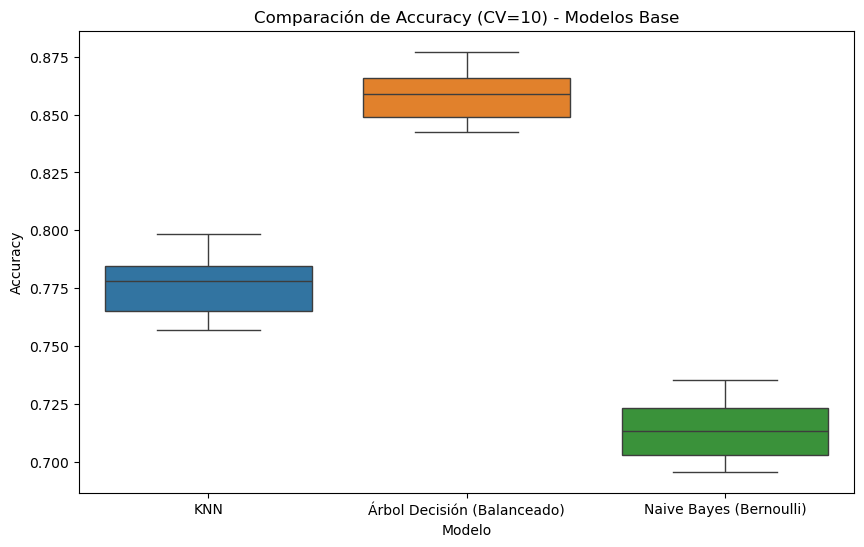

In [19]:
# Convertimos los resultados a un DataFrame
resultados_df = pd.DataFrame(resultados_cv)

plt.figure(figsize=(10, 6))
sns.boxplot(data=resultados_df)
plt.title('Comparación de Accuracy (CV=10) - Modelos Base')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.show()

La validación cruzada (CV) con cv=10 nos da una primera comparativa robusta del rendimiento de los modelos antes de cualquier afinación de hiperparámetros.

- Árbol Decisión (Balanceado) (Media: 0.8578):
    - Es, con diferencia, el mejor modelo base.
    - No solo tiene el accuracy más alto, sino que se puede observar que también es extremadamente estable (std de 0.011).
    - Podemos concluir que la estructura de árbol es adecuada para el ejercicio, tambíen hay que tener en cuenta el parámetro _class_weight='balanced'_ que ayuda a gestionar el desbalanceo que era nuestro principal problema.


- _KNN_ (Media: 0.7767)
    - Ofrece un rendimiento decente y también muy estable (std 0.013), pero claramente por detrás del Árbol de Decisión.
    - Es un buen punto de partida y aun puede mejorar ligeramente si encontramos un valor óptimo de K a la hora de realizar el _GridSearchCV_.


- _Naive Bayes_ (_Bernoulli_) (Media: 0.7137)
    - Este es el modelo ganador de nuestra comparativa previa de variantes de _Naive Bayes_.
    - Con un __71.4% de accuracy__, ofrece un rendimiento funcional. Sin embargo, es claramente el modelo más débil de los tres modelos base.

### Afinación de Hiperparámetros (GridSearchCV)
Por ultimo afinaremos KNN y Árboles de Decisión usando GridSearchCV. Naive Bayes no se puede afinar por lo que es su resultado final.

In [20]:
# Definimos los parametros para KNN
parametros_knn = {
    'classifier__n_neighbors': range(1, 21)
}

print("Iniciando GridSearch para KNN")
grid_knn = GridSearchCV(
    pipe_knn, 
    parametros_knn, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1 
)

grid_knn.fit(X_train, y_train)

print(f"\nMejor K para KNN: {grid_knn.best_params_}")
print(f"Mejor Accuracy (CV): {grid_knn.best_score_:.4f}")

Iniciando GridSearch para KNN
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejor K para KNN: {'classifier__n_neighbors': 6}
Mejor Accuracy (CV): 0.7788


### Afinando Árbol de Decisión

Buscamos la combinación óptima de max_leaf_nodes, min_samples_split y max_depth según lo solicitado en el enunciado.

In [21]:
# Definimos los parametros para el Árbol de decisión
parametros_dt = {
    'classifier__max_leaf_nodes': range(2, 51),
    'classifier__min_samples_split': range(2, 7),
    'classifier__max_depth': range(1, 21)
}

print("Iniciando GridSearch para Árbol de Decisión")
grid_dt = GridSearchCV(
    pipe_dt, 
    parametros_dt, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print(f"\nMejores parámetros para DT: {grid_dt.best_params_}")
print(f"Mejor Accuracy (CV): {grid_dt.best_score_:.4f}")

Iniciando GridSearch para Árbol de Decisión
Fitting 5 folds for each of 4900 candidates, totalling 24500 fits

Mejores parámetros para DT: {'classifier__max_depth': 2, 'classifier__max_leaf_nodes': 3, 'classifier__min_samples_split': 2}
Mejor Accuracy (CV): 0.8427


Estos son los resultados de la afinación:

- KNN (Afinado):
    - Mejor K para KNN: {'classifier__n_neighbors': 6}
    - Mejor Accuracy (CV): 0.7788
    - El modelo base tenía un accuracy de 0.7767. La afinación encontró que K=6 es el parametro optimo, la mejora es muy leve por lo que podemos concluir que el modelo ha llegado a su maximo.


- Árbol Decisión (Afinado):
    - Mejores parámetros: {'classifier__max_depth': 2, 'classifier__max_leaf_nodes': 3, 'classifier__min_samples_split': 2}
    - Mejor Accuracy (CV): 0.8427
    - Podemos concluir que haciendo el _GridSearchCV_ hemos encontrado un árbol mas simple (con los parametros que nos indica el enunciado) pese a que su accuracy sea levemente menor que el árbol complejo
    - Es posible que este árbol generalice mejor en un conjunto de datos que nunca haya visto, debido al _overfitting_

# Valoración
Evaluamos los modelos afinados (y de _Naive Bayes_) en el conjunto de test para poder observar su rendimiento real.

Usaremos los _best_estimator__ de los _GridSearchCV_ (que ya están re-entrenados con todo el train set) y re-entrenaremos el "pipe_nb" en todo el train set.

In [22]:
# Obtenemos los mejores modelos y entrenamos NB
mejor_knn = grid_knn.best_estimator_
mejor_dt = grid_dt.best_estimator_
pipe_nb_bernoulli.fit(X_train, y_train)

modelos_final = {
    "KNN (Afinado)": mejor_knn,
    "Árbol Decisión (Afinado)": mejor_dt,
    "Naive Bayes (Bernoulli)": pipe_nb_bernoulli
}

final_accuracies = {}

print("Evaluación final")

for name, model in modelos_final.items():
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    final_accuracies[name] = accuracy_test
    
    print(f" Modelo: {name}")
    print(f"Accuracy en Test: {accuracy_test:.4f}")
    
    print("\nResultados en detalle:")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_))

Evaluación final
 Modelo: KNN (Afinado)
Accuracy en Test: 0.7767

Resultados en detalle:
                 precision    recall  f1-score   support

Entire home/apt       0.78      0.89      0.83      1586
   Private room       0.77      0.63      0.69      1041
    Shared room       0.42      0.13      0.20        38

       accuracy                           0.78      2665
      macro avg       0.66      0.55      0.57      2665
   weighted avg       0.77      0.78      0.77      2665

 Modelo: Árbol Decisión (Afinado)
Accuracy en Test: 0.8285

Resultados en detalle:
                 precision    recall  f1-score   support

Entire home/apt       0.87      0.93      0.90      1586
   Private room       0.85      0.69      0.76      1041
    Shared room       0.13      0.45      0.20        38

       accuracy                           0.83      2665
      macro avg       0.62      0.69      0.62      2665
   weighted avg       0.85      0.83      0.84      2665

 Modelo: Naive Bayes (Be

### Gráfico Comparativo Final

Para terminar, visualizamos el _accuracy_ final obtenido por cada modelo en el conjunto de test.

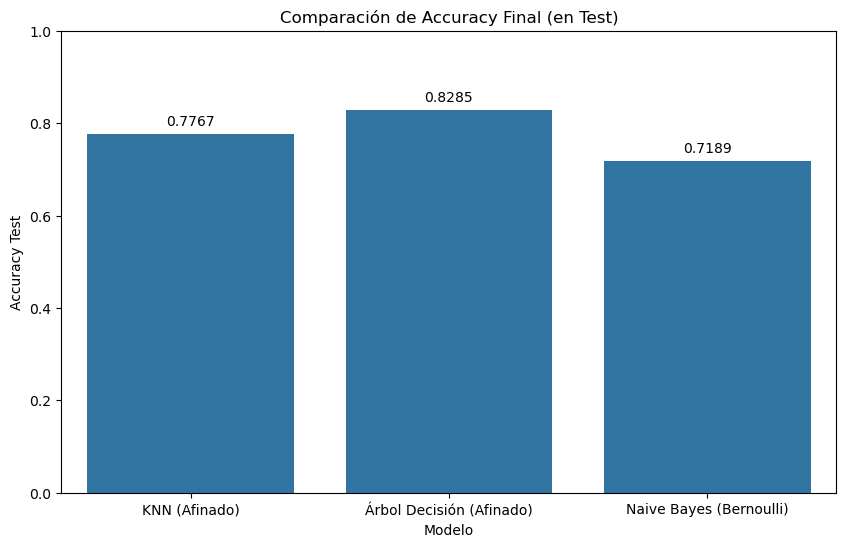

In [23]:
# Gráfico de comparación final
final_acc_df = pd.Series(final_accuracies, name="Accuracy Test").reset_index()
final_acc_df.columns = ['Modelo', 'Accuracy Test']

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Modelo', y='Accuracy Test', data=final_acc_df)
ax.set_title('Comparación de Accuracy Final (en Test)')
ax.set_ylim(0, 1)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

# Conclusiones finales:

Tras realizar el preprocesamiento, la validación cruzada, la afinación de hiperparámetros y la evaluación final sobre el conjunto de test, estas son las principales conclusiones del ejercicio:

#### El Árbol de decisión es el mejor modelo

El Árbol de decisión afinado es el modelo con mejor rendimiento, alcanzando un accuracy final en test del 82.85%. Supera con claridad al KNN afinado, que obtuvo un 77.7%, y a Naive Bayes, que pese a valorar todas sus variantes quedó último con 71.9%. Además, el reporte de clasificación muestra la mejor precisión  y sensibilidad para las clases mayoritarias, demostrando ser el modelo más sólido en general.

#### El problema del desbalanceo

Desde el principio sabíamos que el mayor problema a resolver era el desbalanceo que presenta la variable objetivo, ya que "Shared room" es una clase claramente minoritaria y el numero de ejemplos en el conjunto de test es demasiado baja (38 en este caso), por lo que es importante ver como los modelos han conseguido clasificar en la clase minoritaria:

- _KNN_
    - Presenta una buena _accuracy_ del 77.7% pero para "Shared room" tiene una sensibilidad de tan solo el 0.13, por lo que podemos decir que ha sido un fracaso a la hora de gestionar la clase minoritaria.

- Árbol de decisión
    - No tan solo tiene la mejor _accuracy_ general, si no que ha obtenido una sensibilidad de 0.45, por lo que podemos concluir que es más de un 3.5 veces mejor que _KNN_ en la tarea de encontrar la clase minoritaria.

#### Naive Bayes

El modelo Naive Bayes (Bernoulli) fue el más débil de los tres finalistas, con un accuracy del 72% y una sensibilidad de 0.13 para la clase minoritaria, fallando igualmente en el desbalanceo.
Sin embargo, gracias a la exploración de todos los modelos, pudimos obtener el mejor resultado posible, ya que si hubiesemos hecho el ejercicio con el modelo _GaussianNB_ sin valorar otras opciones, 
hubiesemos obtenido resultados del 14% de _accuracy_
